Hi everyone,

Here, we propose a little improvement of the kaggle script for Giba : https://www.kaggle.com/titericz/0-525-tabular-xgboost-gpu-fft-gpu-cuml-fast about the Kaggle competition : "Rainforest Connection Species Audio Detection"

The code is nearly the same as Giba but we decid to focus the Fourrier transformed only when specy songs are mentioned, and we remove too low frequency and too high frequency for the classification. 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc
import time
import xgboost as xgb
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from scipy.stats import rankdata
import soundfile as sf
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, label_ranking_average_precision_score
import cuml as cm
import cupy as cp

1. Loading files

In [2]:
trainfiles = glob.glob( '../input/rfcx-species-audio-detection/train/*.flac' )
testfiles = glob.glob( '../input/rfcx-species-audio-detection/test/*.flac' )
print('Size of training files :', len(trainfiles))
print('Size of training files :', len(testfiles))

Size of training files : 4727
Size of training files : 1992


2. Separation in training set : True Positive (TP) and False Positive (FP)

In [3]:
Table_train_tp = pd.read_csv( '../input/rfcx-species-audio-detection/train_tp.csv' )
Table_train_fp = pd.read_csv( '../input/rfcx-species-audio-detection/train_fp.csv' )
print('Number of True positive songs in training Data:',Table_train_tp.shape)
print('Number of False positive songs in training Data:',Table_train_fp.shape)

Number of True positive songs in training Data: (1216, 7)
Number of False positive songs in training Data: (7781, 7)


In [4]:
display(Table_train_tp.head())
display(Table_train_fp.head())

recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70

recording_id  species_id  songtype_id    t_min       f_min    t_max  \
0    00204008d          21            1  13.8400   3281.2500  14.9333   
1    00204008d           8            1  24.4960   3750.0000  28.6187   
2    00204008d           4            1  15.0027   2343.7500  16.8587   
3    003b04435          22            1  43.2533  10687.5000  44.8587   
4    003b04435          23            1   9.1254   7235.1562  15.2091   

        f_max  
0   4125.0000  
1   5531.2500  
2   4218.7500  
3  13687.5000  
4  11283.3984

In [5]:
Table_train_tp.describe()

species_id  songtype_id        t_min         f_min        t_max  \
count  1216.000000  1216.000000  1216.000000   1216.000000  1216.000000   
mean     12.023849     1.315789    29.388748   2907.110280    31.925867   
std       7.101400     0.921055    17.488898   2528.642227    17.553856   
min       0.000000     1.000000     0.026700     93.750000     0.666700   
25%       6.000000     1.000000    14.164000    947.461000    16.158150   
50%      12.000000     1.000000    29.514650   2343.750000    31.869350   
75%      18.000000     1.000000    45.257175   3843.750000    48.046800   
max      23.000000     4.000000    59.253300  10687.500000    59.994700   

              f_max  
count   1216.000000  
mean    6043.157895  
std     3468.795425  
min      843.750000  
25%     3937.500000  
50%     5062.500000  
75%     8250.000000  
max    13687.500000

In [6]:
Table_train_fp.describe()

species_id  songtype_id        t_min         f_min        t_max  \
count  7781.000000  7781.000000  7781.000000   7781.000000  7781.000000   
mean     12.138671     1.346999    28.627830   2827.996428    31.267911   
std       7.068808     0.959535    17.461603   2515.604420    17.496989   
min       0.000000     1.000000     0.010700     93.750000     0.768000   
25%       6.000000     1.000000    12.949300    947.460900    15.728000   
50%      12.000000     1.000000    28.880000   2343.750000    31.541300   
75%      18.000000     1.000000    44.065700   3843.750000    46.789300   
max      23.000000     4.000000    59.301300  10687.500000    59.994700   

              f_max  
count   7781.000000  
mean    6074.830415  
std     3386.040304  
min      843.750000  
25%     3937.500000  
50%     5250.000000  
75%     7500.000000  
max    13687.500000

We observe that the lowest frequency of specy songs is located at ~90 Hz and the highest at ~13700 Hz. 

3. Example of processing on 1 file : 

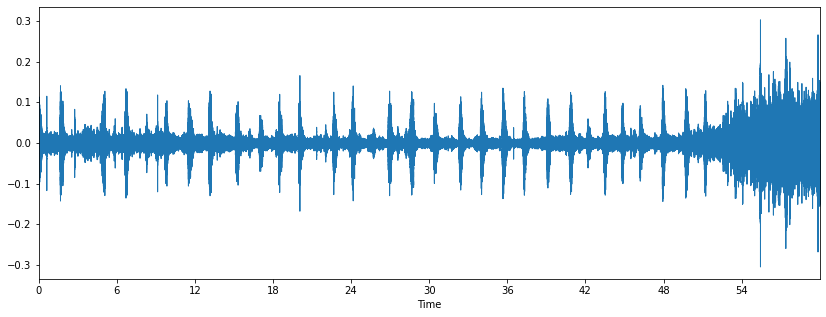

In [7]:
# File Example : 
file_test='/kaggle/input/rfcx-species-audio-detection/train/c12e0a62b.flac'
#file_test='/kaggle/input/rfcx-species-audio-detection/train/03b96f209.flac'
#file_test='/kaggle/input/rfcx-species-audio-detection/train/00204008d.flac'
#file_test='/kaggle/input/rfcx-species-audio-detection/train/003bec244.flac'
#file_test='/kaggle/input/rfcx-species-audio-detection/train/006ab765f.flac'
#file_test='/kaggle/input/rfcx-species-audio-detection/train/003b04435.flac'

x , sr = librosa.load(file_test)


# Plot file 
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

Audio representation of file :

In [8]:
ipd.Audio(file_test)

In [9]:
data, samplerate = sf.read(file_test)

print('The samplerate is ',samplerate,' samples per second (=',samplerate,'Hz)'  )
print('Data is composed by ',samplerate*60,' samples (the file audio lasts 1 min)')

The samplerate is  48000  samples per second (= 48000 Hz)
Data is composed by  2880000  samples (the file audio lasts 1 min)


We're looking for the detected bird periods in file 

In [10]:
Name_file=file_test.split('/')[-1:][0].split('.')[0]

# We look at the species observed in the file test.
Table_file_species=Table_train_tp[Table_train_tp['recording_id']==Name_file].reset_index(drop=True)

display(Table_file_species)

#We create the x-axis for the data 
N = data.shape[0] # number of signal points
T = 1.0/samplerate #(samplerate = sample spacing)
x = np.linspace(0.0, N*T, N)

#We create the y-axis for the data 
y = data #Data


#We search in data when species appeared
index_birds=[]
for n in range(0,Table_file_species.shape[0]):
    index_bird= np.where((x > Table_file_species['t_min'][n]) & (x<Table_file_species['t_max'][n]))[0]
    index_birds=np.concatenate([index_birds, index_bird])
    
index_birds=index_birds.astype(int)

y_birds= y.copy()*0
y_birds[index_birds]=y[index_birds]

recording_id  species_id  songtype_id    t_min    f_min    t_max   f_max
0    c12e0a62b           9            1  14.9653  1125.00  17.7707  5250.0
1    c12e0a62b          17            1   1.5467  1312.50   8.0000  3937.5
2    c12e0a62b          17            1  11.9200  1312.50  18.3733  3937.5
3    c12e0a62b           3            1  21.5680  1031.25  22.3093  2812.5
4    c12e0a62b          17            1  23.4880  1312.50  29.9413  3937.5

We represent the signal and the specy song periods.

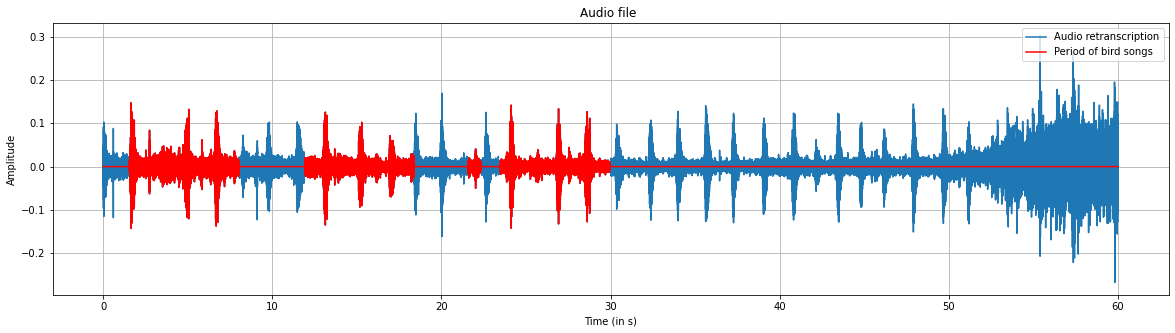

In [11]:
# We represent the original data (in blue) and locations of specy songs (in red)
plt.figure(figsize=(20, 5))
plt.plot(x, y,label="Audio retranscription")
plt.plot(x, y_birds,'r',label="Period of bird songs")
plt.xlabel('Time (in s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.title('Audio file ')
plt.grid()
plt.show()

Then, we apply the Fourrier transform to transform signal in frequency domain and also, only during birds periods.

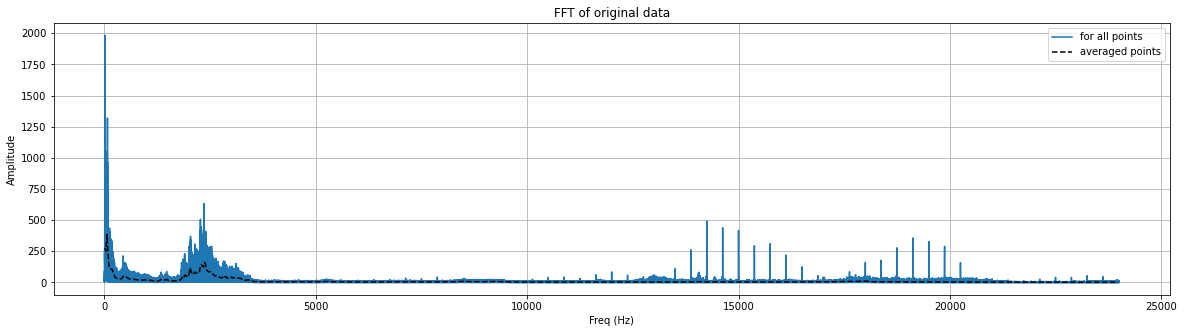

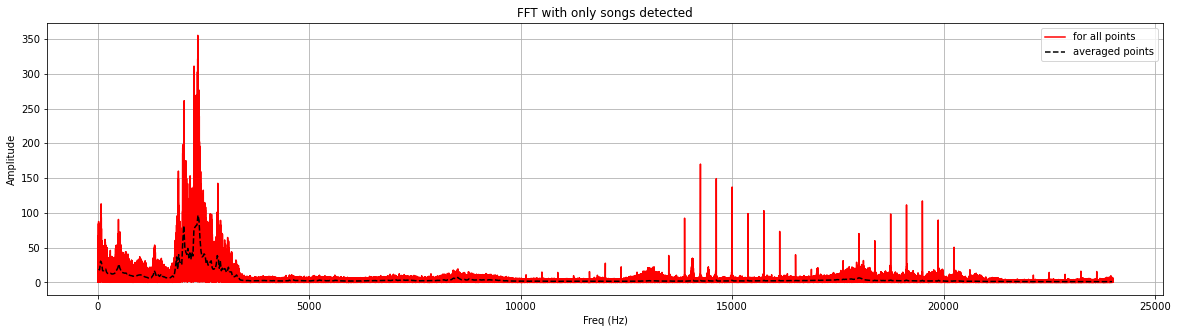

In [12]:
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift, ifft, rfft, irfft

#--------------- TF and example  -----------#
# Here, we transform data in frequency domain 

# we create the x_axis of FFT. 
xf = fftfreq(N, T)
xf_final=xf[:(len(xf)//2)]

# we tansform the original signal with FFT
yf = fft(y)
yf_final=np.abs(yf[:(len(xf)//2)])

# we tansform the signal with only the specy songs with FFT
y_birds = cp.array(y_birds)
yf_birds = cp.abs(cp.fft.fft(y_birds))
yf_birds_final=cp.asnumpy(yf_birds[:(len(xf)//2)])



#--------------- Plot TF  -----------#
plt.figure(figsize=(20, 5))
plt.plot(xf_final,yf_final,label="for all points")
plt.plot(xf_final.reshape( (1000,1440) ).mean(axis=1),yf_final.reshape( (1000,1440) ).mean(axis=1),'k--', label="averaged points")
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of original data')
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(xf_final,yf_birds_final,'r',label="for all points")
plt.plot(xf_final.reshape( (1000,1440) ).mean(axis=1),yf_birds_final.reshape( (1000,1440) ).mean(axis=1),'k--', label="averaged points")
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT with only songs detected')
plt.legend(loc='upper right')
plt.grid()
plt.show()

On the figure, we can observe : 
- the second representation (in red) have the quite same shape than the original data but with lower amplitude. It is due to the fact that we take only few parts of the original data. 
- a large pic in x=0 represent the mean of original signal. 
- the FFT is represented only for frequency in 0 to Fe/2 (Fe = 48000) because the FFT have the same shape (but with mirroiring effect for Frequency between Fe/2 to Fe)

Function creation to extract TFF from file but only when birds are detected

In this function, we decide to remove too high frequencies (i.e. higher than 14000 Hz) and too low frequencies (i.e. lower than 90 Hz) 

In [13]:
def extract_fft_for_birds(fn,Table_train):
    
    data, samplerate = sf.read(fn)
    data = cp.array(data)
    

    Name_file=fn.split('/')[-1:][0].split('.')[0]

    Table_file_species=Table_train[Table_train['recording_id']==Name_file].reset_index(drop=True)

    # number of signal points
    N = data.shape[0]
    
    # sample spacing
    T = 1.0/samplerate
    x = np.linspace(0.0, N*T, N)

    index_birds=[]
    for n in range(0,Table_file_species.shape[0]):
        index_bird= np.where((x > Table_file_species['t_min'][n]) & (x<Table_file_species['t_max'][n]))[0]
        index_birds=np.concatenate([index_birds, index_bird])

    index_birds=index_birds.astype(int)

    y_birds= data.copy()*0
    y_birds[index_birds]=y[index_birds]
    
    
    #--------------- TF and example  -----------#
    xf_final = fftfreq(N, T)[:(len(xf)//2)]
    
    tff_data_final= cp.abs(cp.fft.fft(data)[:(len(xf)//2)])

    tff_y_birds_final = cp.abs(cp.fft.fft(y_birds)[:(len(xf)//2)])

    ## We remove too low frequencies (90 Hz) and too high frequencies(14000 Hz) :
    xf_too_low= np.where(xf_final < 90)[0]
    xf_too_high= np.where(xf_final > 14000)[0]

    tff_y_birds_final[xf_too_low]=0
    tff_y_birds_final[xf_too_high]=0
    
    
    return (cp.asnumpy(xf_final.reshape( (1000,1440) ).mean(axis=1)), cp.asnumpy(tff_y_birds_final.reshape( (1000,1440) ).mean(axis=1)), cp.asnumpy(tff_data_final.reshape( (1000,1440) ).mean(axis=1))  ) #We take the average values every 1000 features.

Test function "extract_fft_for_birds"

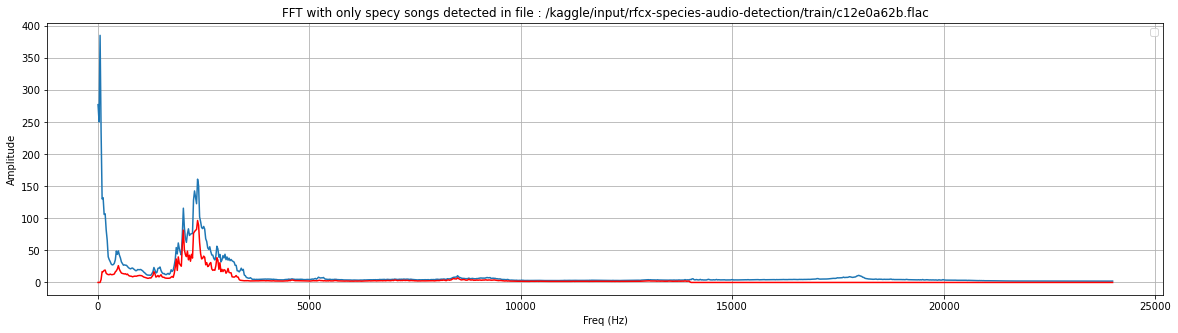

In [14]:
#We verify our fonction on file_test :
fn=file_test

frequency_test,data_test,data_test_origin=extract_fft_for_birds(fn,Table_train_tp)

plt.figure(figsize=(20, 5))
plt.plot(frequency_test,data_test_origin)
plt.plot(frequency_test,data_test,'r')
plt.title('FFT with only specy songs detected in file : '+ fn)
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid()
plt.show()

We run our function on Training Data : 
- first on True positive songs
- secondy on False positive songs 

In [15]:
# This loop runs in 3min using cupy(GPU)
FT = []
for fn in tqdm(Table_train_tp.recording_id.values):
    FT.append( extract_fft_for_birds( '../input/rfcx-species-audio-detection/train/'+fn+'.flac',Table_train_tp ) )
FT = np.stack(FT)
gc.collect()

FT.shape

(1216, 3, 1000)

In [16]:
# This loop runs in 17min using cupy(GPU)

FF = []
for fn in tqdm(Table_train_fp.recording_id.values):
    FF.append( extract_fft_for_birds( '../input/rfcx-species-audio-detection/train/'+fn+'.flac',Table_train_fp ) )
FF = np.stack(FF)
gc.collect()

FF.shape

(7781, 3, 1000)

In [17]:
#Combine True Positives and False Positives

TRAIN_ALL = np.vstack( (FT, FF) )

del FT, FF
gc.collect()
TRAIN_ALL.shape

TRAIN= TRAIN_ALL[:,1,:]
display(TRAIN.shape)

TRAIN_Original= TRAIN_ALL[:,2,:]
display(TRAIN_Original.shape)

(8997, 1000)

(8997, 1000)

In [18]:
tt = Table_train_tp[['recording_id','species_id']].copy()
tf = Table_train_fp[['recording_id','species_id']].copy()
tf['species_id'] = -1

TRAIN_TAB = pd.concat( (tt, tf) )

for i in range(24):
    TRAIN_TAB['s'+str(i)] = 0
    TRAIN_TAB.loc[TRAIN_TAB.species_id==i,'s'+str(i)] = 1

TRAIN_TAB=TRAIN_TAB.reset_index(drop=True)
TRAIN_TAB.head()

recording_id  species_id  s0  s1  s2  s3  s4  s5  s6  s7  ...  s14  s15  \
0    003bec244          14   0   0   0   0   0   0   0   0  ...    1    0   
1    006ab765f          23   0   0   0   0   0   0   0   0  ...    0    0   
2    007f87ba2          12   0   0   0   0   0   0   0   0  ...    0    0   
3    0099c367b          17   0   0   0   0   0   0   0   0  ...    0    0   
4    009b760e6          10   0   0   0   0   0   0   0   0  ...    0    0   

   s16  s17  s18  s19  s20  s21  s22  s23  
0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    1  
2    0    0    0    0    0    0    0    0  
3    0    1    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0  

[5 rows x 26 columns]

In [19]:
def extract_fft_test(fn):
    data, samplerate = sf.read(fn)

    N = data.shape[0] # number of signal points
    T = 1.0/samplerate # sample spacing
    
    data = cp.array(data)
    
    #--------------- TF and example  -----------#
    xf_final = fftfreq(N, T)[:(len(xf)//2)]

    tff_y_final = cp.abs(cp.fft.fft(data)[:(len(xf)//2)])
    
    xf_too_low= np.where(xf_final < 90)[0]
    xf_too_high= np.where(xf_final > 14000)[0]

    tff_y_final[xf_too_low]=0
    tff_y_final[xf_too_high]=0
    

    return (cp.asnumpy(xf_final.reshape( (1000,1440) ).mean(axis=1)), cp.asnumpy(tff_y_final.reshape( (1000,1440) ).mean(axis=1)) ) #We take the average values every 1000 features.

In [20]:
# This loop runs in 3min using cupy(GPU)

TEST_ALL = []
for fn in tqdm(testfiles):
    TEST_ALL.append( extract_fft_test(fn) )
TEST_ALL = np.stack(TEST_ALL)
gc.collect()

TEST_ALL.shape
TEST= TEST_ALL[:,1,:]
display(TEST.shape)

(1992, 1000)

In [21]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit( np.vstack((TRAIN,TEST)) )

TRAIN = std.transform(TRAIN)
TEST  = std.transform(TEST)
gc.collect()

20

In [22]:
# Here we test 4 differents models XGBclassifier, Logistic Regression, SVC and KNN.
from cuml.linear_model import MBSGDClassifier

sub = pd.DataFrame({'recording_id': [f.split('/')[-1].split('.')[0] for f in testfiles] })
sub1=sub.copy()
sub2=sub.copy()
sub3=sub.copy()
sub4=sub.copy()

gkf = GroupKFold(5)

SCORE = []
SCORE1=[]
SCORE2=[]
SCORE3=[]
SCORE4=[]

TRAIN_TAB1=TRAIN_TAB.copy()
TRAIN_TAB2=TRAIN_TAB.copy()
TRAIN_TAB3=TRAIN_TAB.copy()
TRAIN_TAB4=TRAIN_TAB.copy()

groups = TRAIN_TAB['recording_id'].values
for tgt in range(0,24):
    starttime = time.time()
    target = TRAIN_TAB['s'+str(tgt)].values

    ytrain = np.zeros(TRAIN.shape[0])
    ytest = np.zeros(TEST.shape[0])
    
    ytrain1=ytrain.copy()
    ytrain2=ytrain.copy()
    ytrain3=ytrain.copy()
    ytrain4=ytrain.copy()
    
    ytest1=ytest.copy()
    ytest2=ytest.copy()
    ytest3=ytest.copy()
    ytest4=ytest.copy()
    for ind_train, ind_valid in gkf.split( TRAIN, target, groups ):
        
        # Define 4 models
        model1 = xgb.XGBClassifier(n_estimators=1000,
                                   max_depth=4,
                                   learning_rate=0.05,
                                   verbosity=0,
                                   objective='binary:logistic',
                                   subsample=0.95,
                                   colsample_bytree=0.95,
                                   random_state=2021,
                                   tree_method='gpu_hist',
                                   predictor='gpu_predictor',
                                   n_jobs=2,
                                   scale_pos_weight = np.sum(target==0) / np.sum(target==1),
                                  )
        model2 = cm.LogisticRegression( C=1, max_iter=5000 )
        #model3 = cm.svm.SVC(C=1.0, class_weight='balanced', probability=True, kernel='rbf', gamma='scale')
        model3 = cm.ensemble.RandomForestClassifier(n_estimators=1000)
        model4 = cm.neighbors.KNeighborsClassifier(n_neighbors=100)

        # Train using GPUs
        model1.fit( X=TRAIN[ind_train], y=target[ind_train], eval_set=[(TRAIN[ind_valid], target[ind_valid])], eval_metric='auc', early_stopping_rounds=30, verbose=False )
        model2.fit( TRAIN[ind_train], target[ind_train] )
        model3.fit( TRAIN[ind_train].astype(np.float32), target[ind_train] )
        model4.fit( TRAIN[ind_train], target[ind_train] )
        
        # Predict valid and test sets
        yvalid1 = model1.predict_proba(TRAIN[ind_valid])[:,1]
        yvalid2 = model2.predict_proba(TRAIN[ind_valid])[:,1]
        yvalid3 = model3.predict_proba(TRAIN[ind_valid])[:,1]
        yvalid4 = model4.predict_proba(TRAIN[ind_valid])[:,1]
        ytest1 = model1.predict_proba(TEST)[:,1]
        ytest2 = model2.predict_proba(TEST)[:,1]
        ytest3 = model3.predict_proba(TEST)[:,1]
        ytest4 = model4.predict_proba(TEST)[:,1]
        
        #Rank predictions
        SZ = len(ind_valid) + len(ytest1)
        yvalid1 = rankdata( np.concatenate((yvalid1,ytest1)) )[:len(ind_valid)] / SZ
        yvalid2 = rankdata( np.concatenate((yvalid2,ytest2)) )[:len(ind_valid)] / SZ
        yvalid3 = rankdata( np.concatenate((yvalid3,ytest3)) )[:len(ind_valid)] / SZ
        yvalid4 = rankdata( np.concatenate((yvalid4,ytest4)) )[:len(ind_valid)] / SZ
        ytest1 = rankdata( np.concatenate((yvalid1,ytest1)) )[len(ind_valid):] / SZ
        ytest2 = rankdata( np.concatenate((yvalid2,ytest2)) )[len(ind_valid):] / SZ
        ytest3 = rankdata( np.concatenate((yvalid3,ytest3)) )[len(ind_valid):] / SZ
        ytest4 = rankdata( np.concatenate((yvalid4,ytest4)) )[len(ind_valid):] / SZ
        
        #Weighted average models
        
        ytrain1[ind_valid] =  yvalid1
        ytest1            +=  ytest1 / (1.*5)
        
        ytrain2[ind_valid] =  yvalid2
        ytest2            +=  ytest2 / (1.*5)
        
        ytrain3[ind_valid] = yvalid3
        ytest3            += ytest3 / (1.*5)
        
        ytrain4[ind_valid] = yvalid4
        ytest4            += ytest4 / (1.*5)
        
        ytrain[ind_valid] = (0.6*yvalid1 +0.2*yvalid2+ 0.1*yvalid3 +0.1*yvalid4)/4
        ytest += (0.6*ytest1 +0.2*ytest2+ 0.1*ytest3 +0.1*ytest4) / (4.*5)

    score1 = roc_auc_score(target, ytrain1)
    print( 'Target AUC M1', tgt, score1, time.time()-starttime )
    SCORE1.append(score1)
    
    score2 = roc_auc_score(target, ytrain2)
    print( 'Target AUC M2', tgt, score2, time.time()-starttime )
    SCORE2.append(score2)
    
    score3 = roc_auc_score(target, ytrain3)
    print( 'Target AUC M3', tgt, score3, time.time()-starttime )
    SCORE3.append(score3)
    
    score4 = roc_auc_score(target, ytrain4)
    print( 'Target AUC M4', tgt, score4, time.time()-starttime )
    SCORE4.append(score4)
    print( '--------------------------------------')
    
    TRAIN_TAB['y'+str(tgt)] = ytrain
    sub['s'+str(tgt)] = ytest
    
    TRAIN_TAB1['y'+str(tgt)] = ytrain1
    sub1['s'+str(tgt)] = ytest1
    
    TRAIN_TAB2['y'+str(tgt)] = ytrain2
    sub2['s'+str(tgt)] = ytest2
    
    TRAIN_TAB3['y'+str(tgt)] = ytrain3
    sub3['s'+str(tgt)] = ytest3

    TRAIN_TAB4['y'+str(tgt)] = ytrain4
    sub4['s'+str(tgt)] = ytest4
    
print('Overall Score M1:', np.mean(SCORE1) )
print('Overall Score M2:', np.mean(SCORE2) )
print('Overall Score M3:', np.mean(SCORE3) )
print('Overall Score M4:', np.mean(SCORE4) )

Target AUC M1 0 0.9232826645803061 33.62443661689758
Target AUC M2 0 0.7559494802727171 33.62861204147339
Target AUC M3 0 0.8153079244439477 33.631919860839844
Target AUC M4 0 0.8488711299877053 33.6353440284729
--------------------------------------
Target AUC M1 1 0.9652676874930144 27.06728768348694
Target AUC M2 1 0.8090767855146976 27.07106041908264
Target AUC M3 1 0.8896792220856152 27.07425045967102
Target AUC M4 1 0.883852688051861 27.07728934288025
--------------------------------------
Target AUC M1 2 0.8682628499034749 25.53455662727356
Target AUC M2 2 0.6358771718146718 25.53866410255432
Target AUC M3 2 0.780063042953668 25.541894674301147
Target AUC M4 2 0.6719805743243243 25.54493236541748
--------------------------------------
Target AUC M1 3 0.9200760031295405 28.462449550628662
Target AUC M2 3 0.864544540069297 28.466267824172974
Target AUC M3 3 0.8058690063708507 28.469570875167847
Target AUC M4 3 0.858450877389069 28.4726722240448
------------------------------------

In [23]:
import pandas as pd
pd.set_option("display.max_rows", 50,'display.max_columns', 50)
display(TRAIN_TAB[0:50])



recording_id  species_id  s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  \
0     003bec244          14   0   0   0   0   0   0   0   0   0   0    0    0   
1     006ab765f          23   0   0   0   0   0   0   0   0   0   0    0    0   
2     007f87ba2          12   0   0   0   0   0   0   0   0   0   0    0    0   
3     0099c367b          17   0   0   0   0   0   0   0   0   0   0    0    0   
4     009b760e6          10   0   0   0   0   0   0   0   0   0   0    1    0   
5     00b404881           8   0   0   0   0   0   0   0   0   1   0    0    0   
6     00d442df7           0   1   0   0   0   0   0   0   0   0   0    0    0   
7     011f25080          18   0   0   0   0   0   0   0   0   0   0    0    0   
8     015113cad          15   0   0   0   0   0   0   0   0   0   0    0    0   
9     0151b7d20           1   0   1   0   0   0   0   0   0   0   0    0    0   
10    01b41f92b           6   0   0   0   0   0   0   1   0   0   0    0    0   
11    0201197ec          10   0   0   0   0   0   0   0   0   0   0    1    0   
12    0209f7ab2           7   0   0   0   0   0   0   0   1   0   0    0    0   
13    0268057eb           0   1   0   0   0   0   0   0   0   0   0    0    0   
14    0275e127d          11   0   0   0   0   0   0   0   0   0   0    0    1   
15    0295e3234          11   0   0   0   0   0   0   0   0   0   0    0    1   
16    0297d886e          13   0   0   0   0   0   0   0   0   0   0    0    0   
17    02b9a8ab9          12   0   0   0   0   0   0   0   0   0   0    0    0   
18    0313e82cf          16   0   0   0   0   0   0   0   0   0   0    0    0   
19    03b96f209          16   0   0   0   0   0   0   0   0   0   0    0    0   
20    03b96f209          16   0   0   0   0   0   0   0   0   0   0    0    0   
21    03d77fede           0   1   0   0   0   0   0   0   0   0   0    0    0   
22    043356ff8          18   0   0   0   0   0   0   0   0   0   0    0    0   
23    04975ecd8          19   0   0   0   0   0   0   0   0   0   0    0    0   
24    04d6b1fc1          17   0   0   0   0   0   0   0   0   0   0    0    0   
25    04e70a8e3           7   0   0   0   0   0   0   0   1   0   0    0    0   
26    0509303a5           6   0   0   0   0   0   0   1   0   0   0    0    0   
27    050d0ca85           3   0   0   0   1   0   0   0   0   0   0    0    0   
28    053aeb7bd          23   0   0   0   0   0   0   0   0   0   0    0    0   
29    053aeb7bd          23   0   0   0   0   0   0   0   0   0   0    0    0   
30    055088446          14   0   0   0   0   0   0   0   0   0   0    0    0   
31    055d22517          10   0   0   0   0   0   0   0   0   0   0    1    0   
32    057802c25          11   0   0   0   0   0   0   0   0   0   0    0    1   
33    05b9c974c           2   0   0   1   0   0   0   0   0   0   0    0    0   
34    05f8c0f2f           4   0   0   0   0   1   0   0   0   0   0    0    0   
35    067f49f8b           0   1   0   0   0   0   0   0   0   0   0    0    0   
36    068f1b8e2          12   0   0   0   0   0   0   0   0   0   0    0    0   
37    06a0c48c9           0   1   0   0   0   0   0   0   0   0   0    0    0   
38    06c44d203           3   0   0   0   1   0   0   0   0   0   0    0    0   
39    073e4d908          12   0   0   0   0   0   0   0   0   0   0    0    0   
40    078788674          15   0   0   0   0   0   0   0   0   0   0    0    0   
41    07d1687e0           8   0   0   0   0   0   0   0   0   1   0    0    0   
42    07dcf40f7          10   0   0   0   0   0   0   0   0   0   0    1    0   
43    07f1227b0           1   0   1   0   0   0   0   0   0   0   0    0    0   
44    08db743d0          16   0   0   0   0   0   0   0   0   0   0    0    0   
45    090ae427d           7   0   0   0   0   0   0   0   1   0   0    0    0   
46    09315d9bf          22   0   0   0   0   0   0   0   0   0   0    0    0   
47    0968aea09          12   0   0   0   0   0   0   0   0   0   0    0    0   
48    09a946316          23   0   

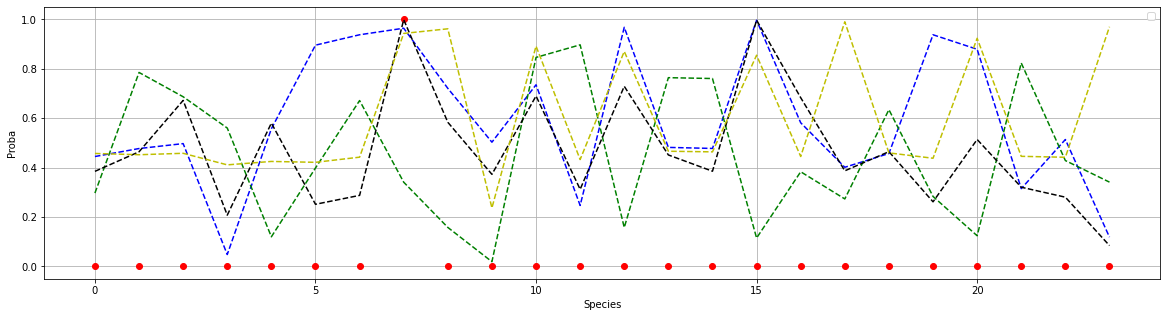

In [24]:
#Comparison between Observed and probabilities on Training Data example.

import random
TRAIN_TAB1_true_species=TRAIN_TAB1[TRAIN_TAB1['species_id']>-1]
TRAIN_TAB2_true_species=TRAIN_TAB2[TRAIN_TAB2['species_id']>-1]
TRAIN_TAB3_true_species=TRAIN_TAB3[TRAIN_TAB3['species_id']>-1]
TRAIN_TAB4_true_species=TRAIN_TAB4[TRAIN_TAB4['species_id']>-1]

rd_index=random.randint(0, len(TRAIN_TAB1_true_species))

TRAIN_TAB1_test=TRAIN_TAB1_true_species.iloc[rd_index,:]
TRAIN_TAB2_test=TRAIN_TAB2_true_species.iloc[rd_index,:]
TRAIN_TAB3_test=TRAIN_TAB3_true_species.iloc[rd_index,:]
TRAIN_TAB4_test=TRAIN_TAB4_true_species.iloc[rd_index,:]

#print(TRAIN_TAB1_test)

plt.figure(figsize=(20, 5))
plt.plot(range(0,24),TRAIN_TAB1_test[2:26],'ro')
plt.plot(range(0,24),TRAIN_TAB1_test[26:51],'b--')
plt.plot(range(0,24),TRAIN_TAB2_test[26:51],'g--')
plt.plot(range(0,24),TRAIN_TAB3_test[26:51],'k--')
plt.plot(range(0,24),TRAIN_TAB4_test[26:51],'y--')
plt.xlabel('Species')
plt.ylabel('Proba')
plt.legend(loc='upper right')
plt.grid()
plt.show()

XGBClassifier is the best model. We keep it for the submission

In [25]:
sub_final=sub1.copy()

Final Submission

In [26]:
sub_final.to_csv('submission.csv', index=False)